## <en><center>Frantz Alexander</center></en>

<blockquote>Bankruptcy data from the Taiwan Economic Journal for the years 1999–2009 
    <br>Goals: predict company Bankruptcy 
    <br> Learn which feature variables are the most important factors for company bankruptcy. <blockquote>

# <en><center>Libraries</center></en>

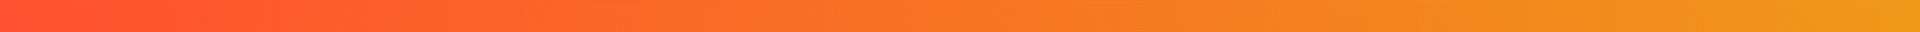

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from imblearn.over_sampling import RandomOverSampler
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression 
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.metrics import (
    roc_auc_score, 
    ConfusionMatrixDisplay,
    classification_report,
    accuracy_score,
    confusion_matrix
)

from sklearn.model_selection import GridSearchCV, train_test_split

from sklearn.feature_selection import (
    f_classif,
    mutual_info_classif, 
    SelectKBest, 
    SelectPercentile
)

from feature_engine.selection import (
    DropConstantFeatures,
    DropDuplicateFeatures,
    SmartCorrelatedSelection
)

%matplotlib inline

plt.style.use("dark_background")

---

# <en><center>Data Preparation</center></en>

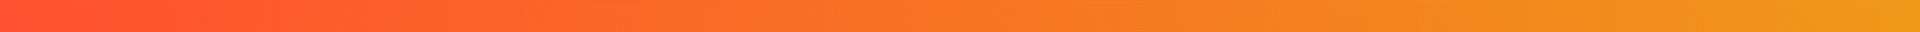

## Import Dataset

In [2]:
def wrangle(filepath):
    df = pd.read_csv(filepath)
    
    # Correct column name formatting
    df.columns = df.columns.str.strip()
    
    # Rename Target column
    df = df.rename(columns = {"Bankrupt?" : "Bankrupt"})
    
    return df

In [3]:
data = wrangle("data.csv")

In [4]:
df = data.copy()

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6819 entries, 0 to 6818
Data columns (total 96 columns):
 #   Column                                                   Non-Null Count  Dtype  
---  ------                                                   --------------  -----  
 0   Bankrupt                                                 6819 non-null   int64  
 1   ROA(C) before interest and depreciation before interest  6819 non-null   float64
 2   ROA(A) before interest and % after tax                   6819 non-null   float64
 3   ROA(B) before interest and depreciation after tax        6819 non-null   float64
 4   Operating Gross Margin                                   6819 non-null   float64
 5   Realized Sales Gross Margin                              6819 non-null   float64
 6   Operating Profit Rate                                    6819 non-null   float64
 7   Pre-tax net Interest Rate                                6819 non-null   float64
 8   After-tax net Interest Rate 

<blockquote> There are no missing values in the dataset.</blockquote>

In [6]:
for column in df.columns:
    if df[column].isnull().sum() > 0:
        print(column)

In [7]:
df.describe()

,Bankrupt,ROA(C) before interest and depreciation before interest,ROA(A) before interest and % after tax,ROA(B) before interest and depreciation after tax,Operating Gross Margin,Realized Sales Gross Margin,Operating Profit Rate,Pre-tax net Interest Rate,After-tax net Interest Rate,Non-industry income and expenditure/revenue,...,Net Income to Total Assets,Total assets to GNP price,No-credit Interval,Gross Profit to Sales,Net Income to Stockholder's Equity,Liability to Equity,Degree of Financial Leverage (DFL),Interest Coverage Ratio (Interest expense to EBIT),Net Income Flag,Equity to Liability
count,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,...,6819.000000,6.819000e+03,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.0,6819.000000
mean,0.032263,0.505180,0.558625,0.553589,0.607948,0.607929,0.998755,0.797190,0.809084,0.303623,...,0.807760,1.862942e+07,0.623915,0.607946,0.840402,0.280365,0.027541,0.565358,1.0,0.047578
std,0.176710,0.060686,0.065620,0.061595,0.016934,0.016916,0.013010,0.012869,0.013601,0.011163,...,0.040332,3.764501e+08,0.012290,0.016934,0.014523,0.014463,0.015668,0.013214,0.0,0.050014
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,0.000000
25%,0.000000,0.476527,0.535543,0.527277,0.600445,0.600434,0.998969,0.797386,0.809312,0.303466,...,0.796750,9.036205e-04,0.623636,0.600443,0.840115,0.276944,0.026791,0.565158,1.0,0.024477
50%,0.000000,0.502706,0.559802,0.552278,0.605997,0.605976,0.999022,0.797464,0.809375,0.303525,...,0.810619,2.085213e-03,0.623879,0.605998,0.841179,0.278778,0.026808,0.565252,1.0,0.033798
75%,0.000000,0.535563,0.589157,0.584105,0.613914,0.613842,0.999095,0.797579,0.809469,0.303585,...,0.826455,5.269777e-03,0.624168,0.613913,0.842357,0.281449,0.026913,0.565725,1.0,0.052838
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,9.820000e+09,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.0,1.000000


---

## Data Exploration

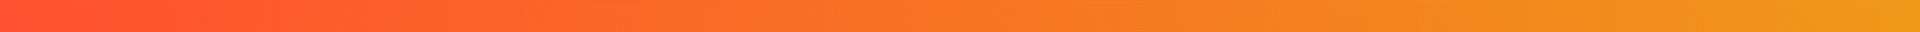

Checking the percentage of the Majority and Minority Classes

In [8]:
df["Bankrupt"].value_counts(normalize = True)

Bankrupt
0    0.967737
1    0.032263
Name: proportion, dtype: float64

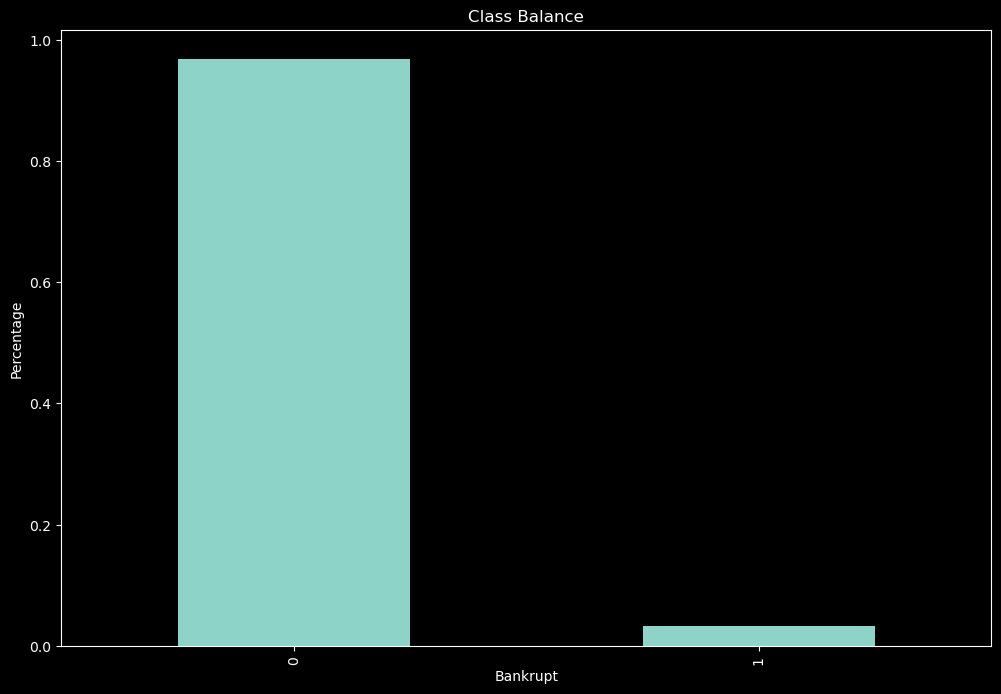

In [9]:
fig, ax = plt.subplots(figsize = (12, 8))

df["Bankrupt"].value_counts(normalize = True).plot(kind = "bar")

plt.xlabel("Bankrupt")
plt.ylabel("Percentage")
plt.title("Class Balance");

<blockquote> The Majority Class is the class with the highest frequency.
    <br>In this case, it is represented as 0. 
    <br>Which is also referring to the companies that did not go bankrupt.
    <br>The Minority Class is the class with the fewest frequency.
    <br>In this case the minority class is represented as 1.
    <br>This is also referring to the companies that experienced bankruptcy.
</blockquote>

<blockquote>
<p>The Majority Class is the class with the highest frequency.
    In this case, it is represented as 0. 
    Which is also referring to the companies that did not go bankrupt.
    The Minority Class is the class with the fewest frequency.
    In this case the minority class is represented as 1.
    This is also referring to the companies that experienced bankruptcy.</p>
</blockquote>

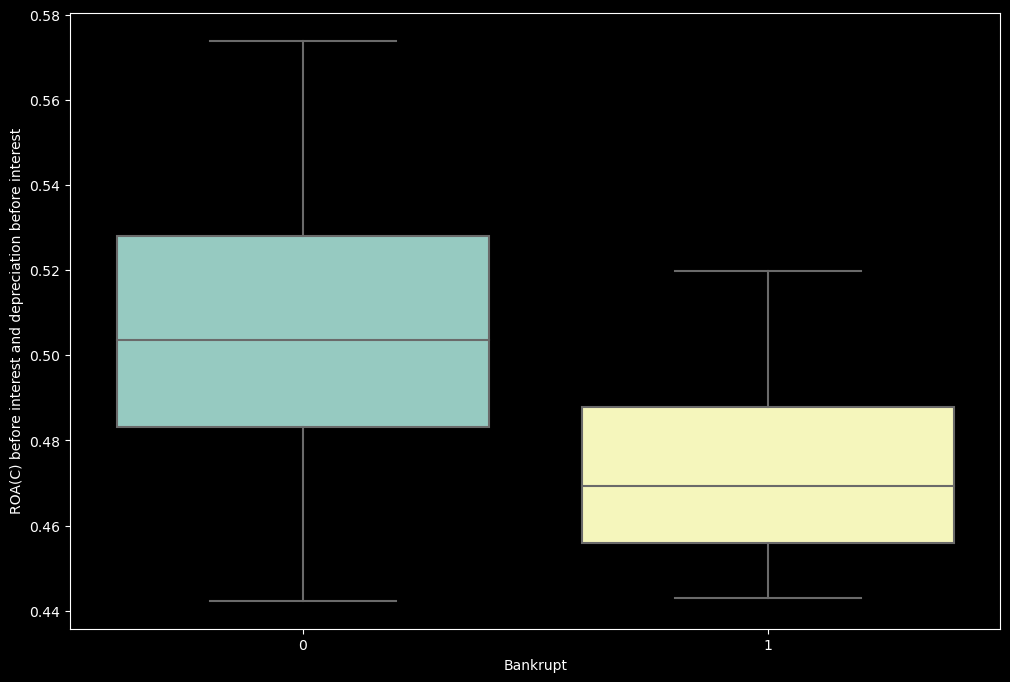

In [10]:
fig, ax = plt.subplots(figsize = (12, 8))


low, high = df["ROA(C) before interest and depreciation before interest"].quantile([0.1, 0.9])
mask = df["ROA(C) before interest and depreciation before interest"].between(low, high)
sns.boxplot(
    data = df[mask],
    x = "Bankrupt",
    y = "ROA(C) before interest and depreciation before interest"
);

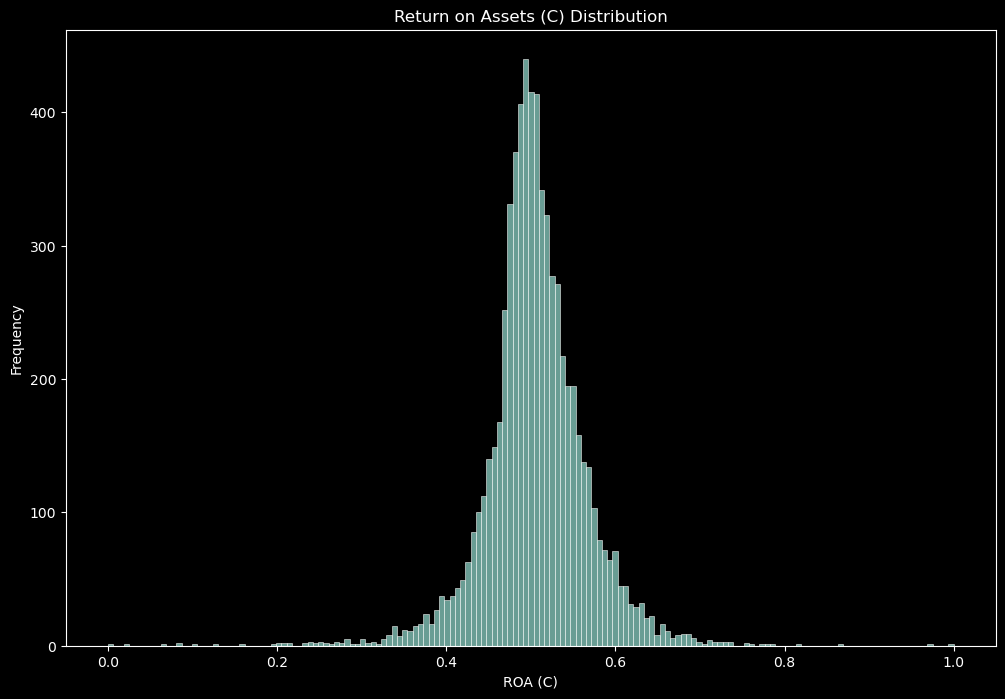

In [11]:
fig, ax = plt.subplots(figsize = (12, 8))
sns.histplot(
    data = df,
    x = df["ROA(C) before interest and depreciation before interest"]
)
plt.xlabel("ROA (C)")
plt.ylabel("Frequency")
plt.title("Return on Assets (C) Distribution");

In [ ]:
fig, ax = plt.subplots(figsize = (12, 8))
sns.histplot(
    data = df,
    x = df["ROA(C) before interest and depreciation before interest"]
)
plt.xlabel("ROA (C)")
plt.ylabel("Frequency")
plt.title("Return on Assets (C) Distribution");

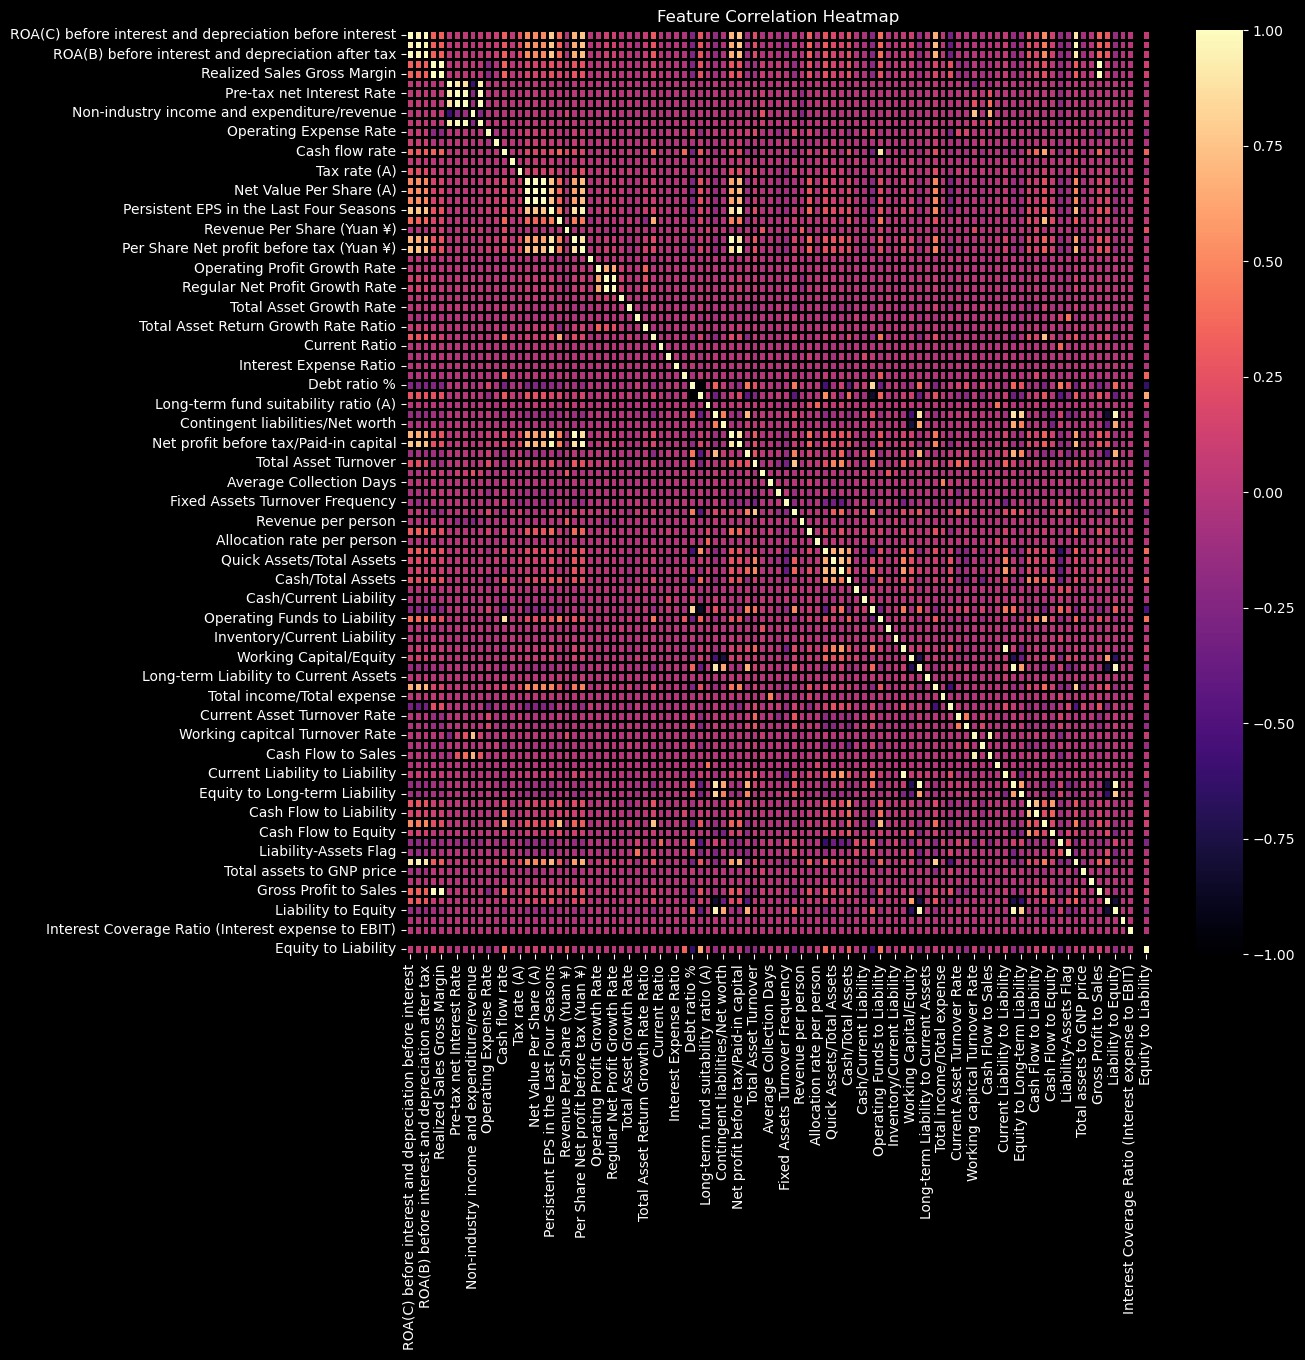

In [12]:
corr = df.drop(columns = "Bankrupt").corr()
 
fig, ax = plt.subplots(figsize = (12,12))
sns.heatmap(
    corr,
    cmap = "magma",
    linecolor = "black",
    linewidth = 1)
plt.title("Feature Correlation Heatmap");

## Train-Test Split

In [13]:
target = "Bankrupt"
X = df.drop(columns = target, axis = 1)
y = df[target]

print("Shape of X:", X.shape)
print("Shape of y:", y.shape)

Shape of X: (6819, 95)
Shape of y: (6819,)


In [14]:
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size = 0.2,
    random_state = 42
)

### Feature Selection

In [15]:
corrmat = X_train.corr()
corrmat = corrmat.abs().unstack()
corrmat = corrmat.sort_values(ascending=False)
corrmat = corrmat[corrmat >= 0.8]
corrmat = corrmat[corrmat < 1]
corrmat = pd.DataFrame(corrmat).reset_index()
corrmat.columns = ["feature1", "feature2", "corr"]
corrmat.head()

,feature1,feature2,corr
0,Net worth/Assets,Debt ratio %,1.000000
1,Debt ratio %,Net worth/Assets,1.000000
2,Operating Gross Margin,Gross Profit to Sales,1.000000
3,Gross Profit to Sales,Operating Gross Margin,1.000000
4,Net Value Per Share (C),Net Value Per Share (A),0.999886


In [16]:
grouped_feature_1s = []
correlated_groups = []

for feature in corrmat["feature1"].unique():
    if feature not in grouped_feature_1s:
        correlated_block = corrmat[corrmat["feature1"] == feature]
        grouped_feature_1s = grouped_feature_1s + list(
            correlated_block["feature2"].unique()
        ) + [feature]
        
        correlated_groups.append(correlated_block)
        
print('found {} correlated groups'.format(len(correlated_groups)))
print('out of {} total features'.format(X_train.shape[1]))

found 15 correlated groups
out of 95 total features


In [17]:
for group in correlated_groups:
    print(group)
    print()

            feature1                     feature2      corr
0   Net worth/Assets                 Debt ratio %  1.000000
79  Net worth/Assets  Current Liability to Assets  0.844086

                 feature1                     feature2      corr
2  Operating Gross Margin        Gross Profit to Sales  1.000000
7  Operating Gross Margin  Realized Sales Gross Margin  0.999514

                   feature1                 feature2      corr
4   Net Value Per Share (C)  Net Value Per Share (A)  0.999886
12  Net Value Per Share (C)  Net Value Per Share (B)  0.999149

                               feature1  \
14  Operating Profit Per Share (Yuan ¥)   
54  Operating Profit Per Share (Yuan ¥)   
62  Operating Profit Per Share (Yuan ¥)   
71  Operating Profit Per Share (Yuan ¥)   

                                    feature2      corr  
14          Operating profit/Paid-in capital  0.998536  
54     Net profit before tax/Paid-in capital  0.890831  
62   Persistent EPS in the Last Four Seasons  

In [18]:
X_train["Operating Gross Margin"].head()

3759    0.599194
1782    0.609334
5013    0.614242
5412    0.597825
3066    0.600362
Name: Operating Gross Margin, dtype: float64

In [19]:
group = correlated_groups[1]
group

,feature1,feature2,corr
2,Operating Gross Margin,Gross Profit to Sales,1.000000
7,Operating Gross Margin,Realized Sales Gross Margin,0.999514


In [20]:
rf = RandomForestClassifier(
    n_estimators=200,
    random_state=42,
    n_jobs=4,
)

In [21]:
features = list(group["feature2"].unique()) + [group.iloc[0,0]]
rf.fit(X_train[features], y_train)

RandomForestClassifier(n_estimators=200, n_jobs=4, random_state=42)

In [22]:
importances = pd.concat(
    [pd.Series(features),
    pd.Series(rf.feature_importances_)],
    axis = 1
)
importances.columns = ["feature","importance"]

importances.sort_values(by = "importance", ascending = False)

,feature,importance
0,Gross Profit to Sales,0.418078
2,Operating Gross Margin,0.300028
1,Realized Sales Gross Margin,0.281895


In [23]:
for group in correlated_groups:
    features = list(group["feature2"].unique()) + [group.iloc[0,0]]
    rf.fit(X_train[features], y_train)
    importances = pd.concat(
        [pd.Series(features),
        pd.Series(rf.feature_importances_)],
        axis = 1
    )
    importances.columns = ["feature","importance"]

    print(importances.sort_values(by = "importance", ascending = False))
    print()

                       feature  importance
1  Current Liability to Assets    0.335175
2             Net worth/Assets    0.333371
0                 Debt ratio %    0.331454

                       feature  importance
0        Gross Profit to Sales    0.418078
2       Operating Gross Margin    0.300028
1  Realized Sales Gross Margin    0.281895

                   feature  importance
2  Net Value Per Share (C)    0.337973
1  Net Value Per Share (B)    0.334914
0  Net Value Per Share (A)    0.327113

                                    feature  importance
2   Persistent EPS in the Last Four Seasons    0.242718
1     Net profit before tax/Paid-in capital    0.210774
3  Per Share Net profit before tax (Yuan ¥)    0.190207
0          Operating profit/Paid-in capital    0.184843
4       Operating Profit Per Share (Yuan ¥)    0.171459

                            feature  importance
0  After-tax Net Profit Growth Rate    0.503506
1    Regular Net Profit Growth Rate    0.496494

               

In [24]:
pipe = Pipeline([
    ("constant", DropConstantFeatures(tol = 0.998)),
    ("duplicated", DropDuplicateFeatures()),
    ("correlation", SmartCorrelatedSelection(
        variables = None,
        method = "pearson",
        threshold = 0.8,
        selection_method="model_performance",
        estimator = rf,
        scoring = "roc_auc",
        cv = 3
        )
    )
])

In [25]:
pipe.fit(X_train, y_train)

Pipeline(steps=[('constant', DropConstantFeatures(tol=0.998)),
                ('duplicated', DropDuplicateFeatures()),
                ('correlation',
                 SmartCorrelatedSelection(estimator=RandomForestClassifier(n_estimators=200,
                                                                           n_jobs=4,
                                                                           random_state=42),
                                          selection_method='model_performance'))])

In [26]:
pipe["constant"].features_to_drop_

['Liability-Assets Flag', 'Net Income Flag']

In [27]:
pipe["duplicated"].features_to_drop_

{'Current Liability to Equity', 'Current Liability to Liability'}

In [28]:
pipe["correlation"].features_to_drop_

['ROA(C) before interest and depreciation before interest',
 'ROA(A) before interest and % after tax',
 'ROA(B) before interest and depreciation after tax',
 'Realized Sales Gross Margin',
 'Operating Profit Rate',
 'Pre-tax net Interest Rate',
 'After-tax net Interest Rate',
 'Cash flow rate',
 'Net Value Per Share (B)',
 'Net Value Per Share (A)',
 'Operating Profit Per Share (Yuan ¥)',
 'Per Share Net profit before tax (Yuan ¥)',
 'After-tax Net Profit Growth Rate',
 'Cash Reinvestment %',
 'Debt ratio %',
 'Borrowing dependency',
 'Operating profit/Paid-in capital',
 'Net profit before tax/Paid-in capital',
 'Current Liability to Assets',
 'Current Liabilities/Equity',
 'Working capitcal Turnover Rate',
 'Equity to Long-term Liability',
 'Gross Profit to Sales',
 'Liability to Equity']

These are the groups of correlated features in the dataset. 

In [29]:
pipe["correlation"].correlated_feature_sets_

[{'Net Income to Total Assets',
  'ROA(A) before interest and % after tax',
  'ROA(B) before interest and depreciation after tax',
  'ROA(C) before interest and depreciation before interest'},
 {'Gross Profit to Sales',
  'Operating Gross Margin',
  'Realized Sales Gross Margin'},
 {'After-tax net Interest Rate',
  'Continuous interest rate (after tax)',
  'Operating Profit Rate',
  'Pre-tax net Interest Rate'},
 {'Cash flow rate', 'Operating Funds to Liability'},
 {'Net Value Per Share (A)',
  'Net Value Per Share (B)',
  'Net Value Per Share (C)'},
 {'Net profit before tax/Paid-in capital',
  'Operating Profit Per Share (Yuan ¥)',
  'Operating profit/Paid-in capital',
  'Per Share Net profit before tax (Yuan ¥)',
  'Persistent EPS in the Last Four Seasons'},
 {'After-tax Net Profit Growth Rate', 'Regular Net Profit Growth Rate'},
 {'CFO to Assets', 'Cash Reinvestment %'},
 {'Current Liability to Assets', 'Debt ratio %', 'Net worth/Assets'},
 {'Borrowing dependency',
  'Current Liabil

### Remove Correlated, Constant and Duplicated Features

In [30]:
X_train = pipe.transform(X_train)
X_test = pipe.transform(X_test)

X_train.shape, X_test.shape

((5455, 67), (1364, 67))

28 features were removed 

### Calculate the Mutual Information between the variables and the target.
<br>The smaller the value of the Mutual Information, the less information we can infer from the feature about the target. 

In [31]:
mi = mutual_info_classif(
    X_train.fillna(0), y_train
)
mi

array([0.01288948, 0.0244228 , 0.03201855, 0.00104505, 0.        ,
       0.        , 0.01359762, 0.02784657, 0.04015763, 0.00749145,
       0.        , 0.00596925, 0.00280915, 0.0118857 , 0.0101047 ,
       0.01149388, 0.00308098, 0.0084366 , 0.00977377, 0.00218547,
       0.03370553, 0.00572637, 0.03068201, 0.0099905 , 0.00442535,
       0.00430454, 0.00429078, 0.        , 0.        , 0.        ,
       0.00306471, 0.00131888, 0.        , 0.01569356, 0.0057235 ,
       0.02127827, 0.00585749, 0.        , 0.01267185, 0.00240988,
       0.00501445, 0.01349973, 0.01603026, 0.00029237, 0.00158764,
       0.02012045, 0.0008466 , 0.02951912, 0.02810724, 0.00756054,
       0.        , 0.00034266, 0.00736357, 0.00385043, 0.00049057,
       0.00519453, 0.00856495, 0.00823713, 0.00921917, 0.02252267,
       0.03589246, 0.        , 0.00466872, 0.0376464 , 0.03156302,
       0.03209304, 0.0301894 ])

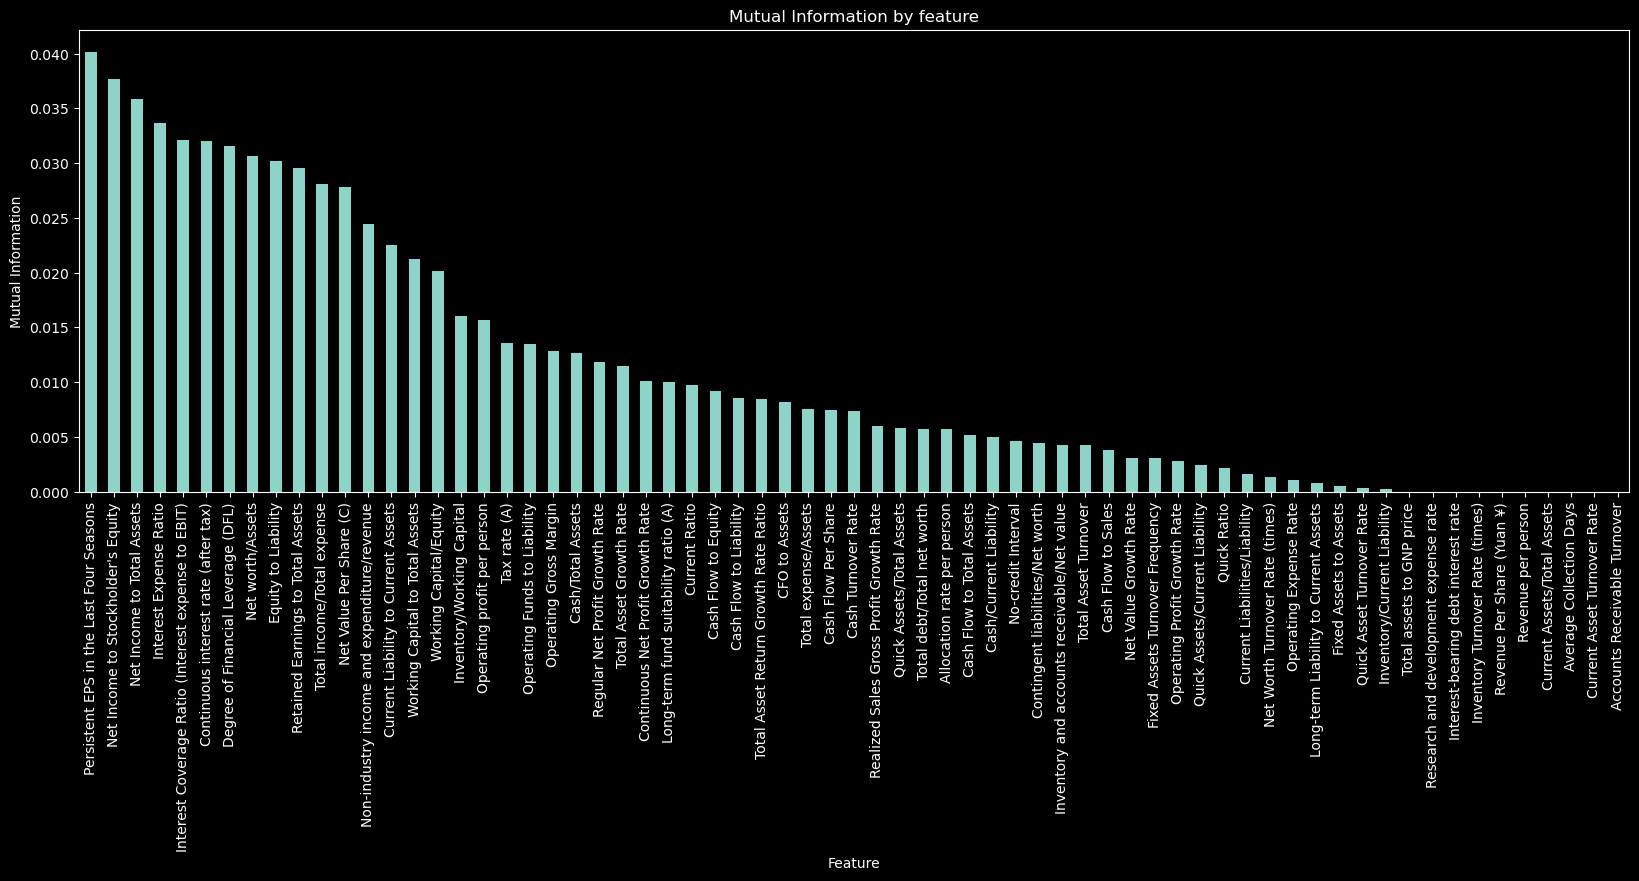

In [32]:
df_mi = pd.Series(mi)
df_mi.index = X_train.columns
df_mi.sort_values(ascending= False).plot.bar(figsize = (20, 6))
plt.xlabel("Feature")
plt.ylabel("Mutual Information")
plt.title("Mutual Information by feature");

<blockquote>There are a quite a features (left of the plot) with higher mutual information values.<blockquote>

Determine Univariate ANOVA P-Values

In [33]:
univariate = f_classif(X_train, y_train)
univariate

(array([3.94186370e+01, 1.60368168e+00, 2.96024260e-01, 5.62235597e-01,
        2.71570315e+00, 2.42287865e+00, 5.56476687e+01, 1.38525468e+02,
        2.36935630e+02, 2.16611617e+01, 1.14218326e-01, 3.49943078e-03,
        1.38575652e+00, 7.53068164e+00, 5.60096596e-01, 1.36707104e+01,
        3.19655703e-02, 1.27834638e+00, 3.19655712e-02, 8.46192874e+00,
        1.51226862e-04, 1.14959982e+00, 3.32584744e+02, 2.57061423e-01,
        3.55700080e+01, 7.30013333e+01, 1.83205786e+01, 5.74981129e-02,
        1.88315839e-01, 6.59223240e-01, 2.49382685e+01, 1.83513896e+00,
        1.12773583e+01, 4.70965306e+01, 2.64384731e-01, 1.93040230e+02,
        2.93712267e+01, 8.79959701e+00, 4.68258316e+01, 6.38497134e-02,
        3.89407276e+01, 3.10684950e+01, 8.35925590e-04, 2.06031983e-01,
        6.13946588e-01, 1.35545960e+02, 4.40400487e-01, 2.66154370e+02,
        2.50981153e-01, 1.12926144e+02, 8.81705437e-02, 2.55872962e+00,
        3.16569892e+00, 2.44409140e-03, 2.01878045e+01, 2.879651

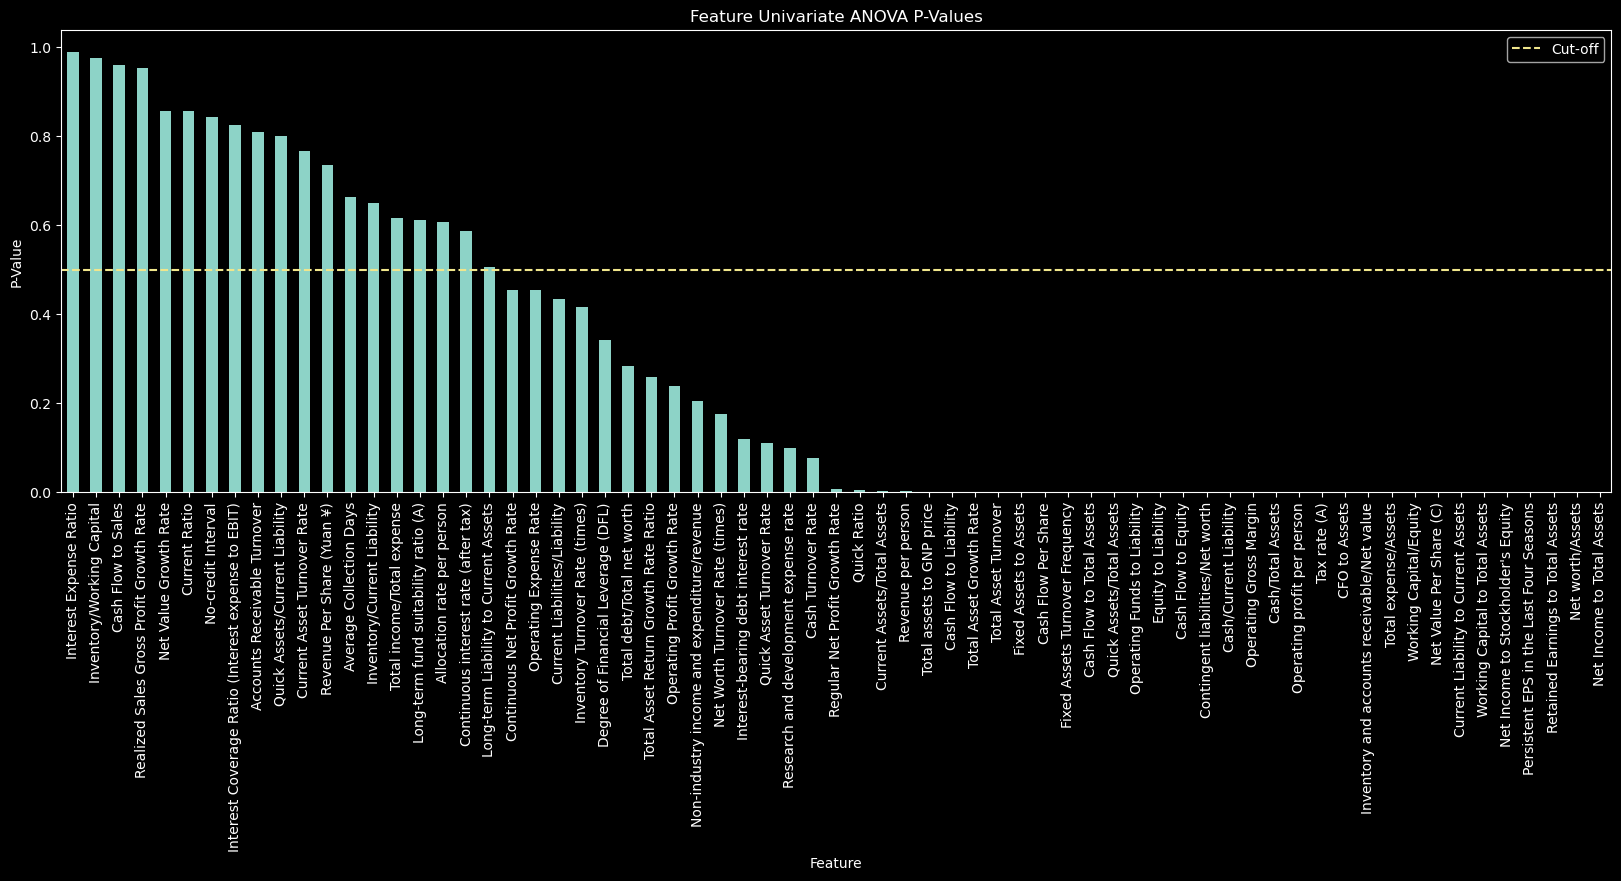

In [40]:
univariate_df = pd.Series(univariate[1])
univariate_df.index = X_train.columns
univariate_df.sort_values(ascending = False).plot.bar(figsize = (20, 6))
plt.axhline(
    y = 0.5,
    color = "khaki",
    linestyle = "--",
    label = "Cut-off"
)
plt.xlabel("Feature")
plt.ylabel("P-Value")
plt.title("Feature Univariate ANOVA P-Values")
plt.legend();

In [43]:
len(univariate_df[univariate_df > 0.5])

19

There are 19 features with P-Values above 0.5

### Univariate model performance metrics
Feature selection process that builds machine learning models utilizing single features. <br>This is in order to obtain a performance metric that is attributed to the feature.

Determine the roc-auc metric for each feature by building Decision Trees.

In [36]:
roc_values = []

for feature in X_train.columns:
    clf = DecisionTreeClassifier(random_state = 42)
    clf.fit(X_train[feature].fillna(0).to_frame(), y_train)
    y_scored = clf.predict_proba(X_test[feature].to_frame())
    roc_values.append(roc_auc_score(y_test, y_scored[:, 1]))
    
roc_values[0:10]

[0.5277541328793512,
 0.5774980212953422,
 0.5242671325956125,
 0.4948628346997595,
 0.5936039305287995,
 0.46123232232725525,
 0.7841494556695487,
 0.5952316951152129,
 0.5438824425428969,
 0.5091244418559503]

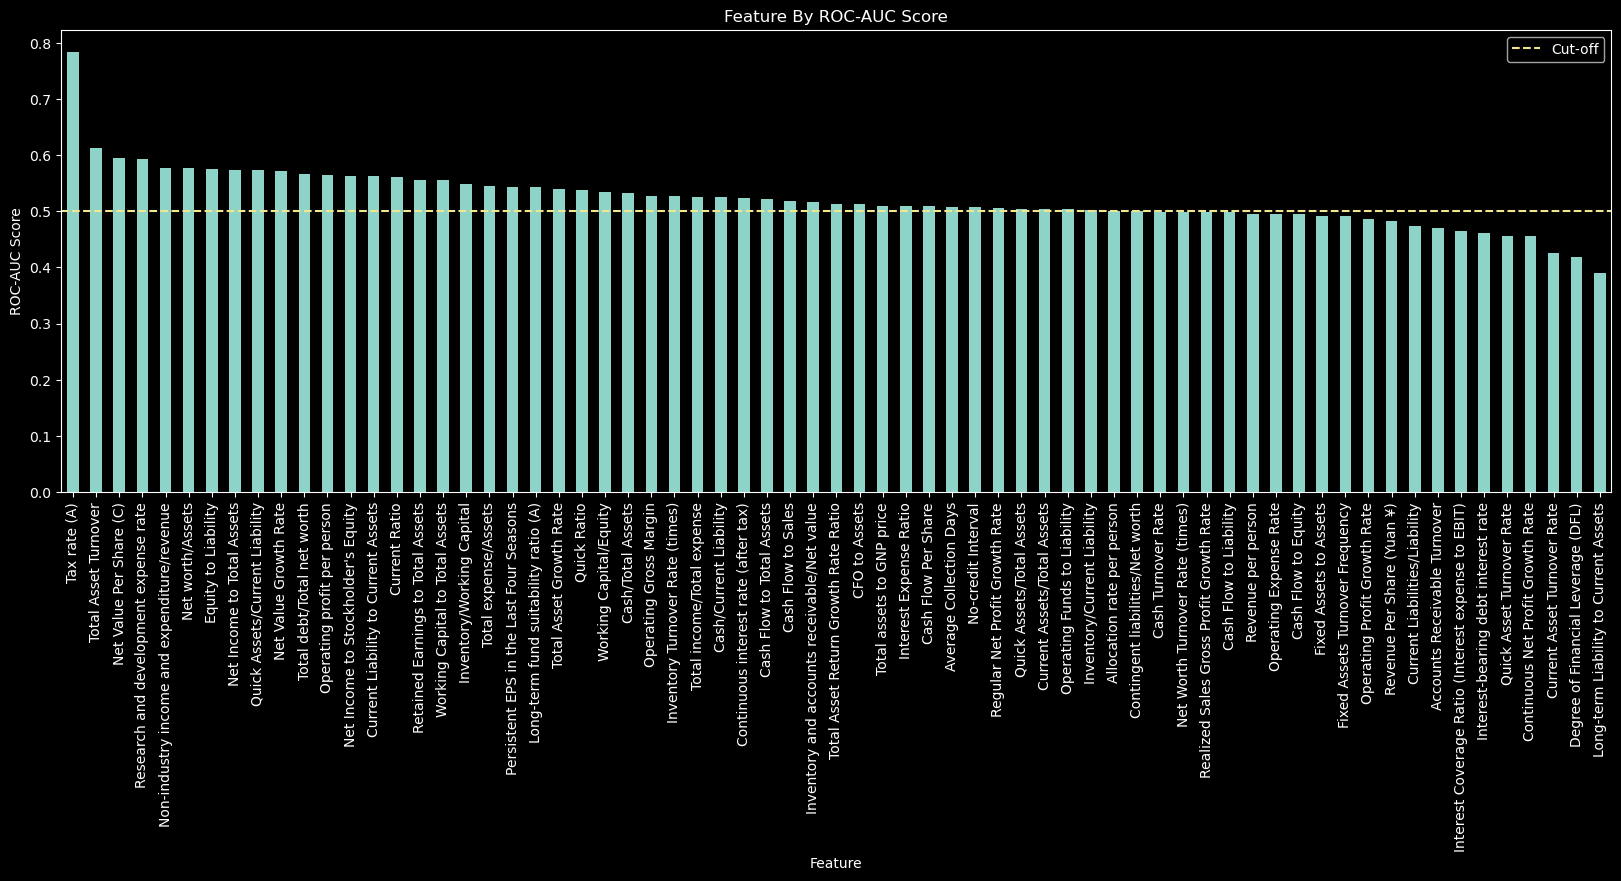

In [41]:
roc_values = pd.Series(roc_values)
roc_values.index = X_train.columns
roc_values.sort_values(ascending = False).plot.bar(figsize = (20, 6))
plt.axhline(
    y = 0.5,
    linestyle = "--",
    color = "khaki",
    label = "Cut-off"
    )
plt.xlabel("Feature")
plt.ylabel("ROC-AUC Score")
plt.title("Feature By ROC-AUC Score")
plt.legend();

In [42]:
len(roc_values[roc_values > 0.5])

46

In [44]:
len(X_train.columns)

67

A ROC-AUC score of 0.5 indicates a random decision by the Decision Tree model. 
<br>There are 46 out of 67 features with predictive performance above 0.5.

In [45]:
roc_values[roc_values > 0.5].index

Index(['Operating Gross Margin', 'Non-industry income and expenditure/revenue',
       'Continuous interest rate (after tax)',
       'Research and development expense rate', 'Tax rate (A)',
       'Net Value Per Share (C)', 'Persistent EPS in the Last Four Seasons',
       'Cash Flow Per Share', 'Regular Net Profit Growth Rate',
       'Total Asset Growth Rate', 'Net Value Growth Rate',
       'Total Asset Return Growth Rate Ratio', 'Current Ratio', 'Quick Ratio',
       'Interest Expense Ratio', 'Total debt/Total net worth',
       'Net worth/Assets', 'Long-term fund suitability ratio (A)',
       'Inventory and accounts receivable/Net value', 'Total Asset Turnover',
       'Average Collection Days', 'Inventory Turnover Rate (times)',
       'Operating profit per person', 'Allocation rate per person',
       'Working Capital to Total Assets', 'Quick Assets/Total Assets',
       'Current Assets/Total Assets', 'Cash/Total Assets',
       'Quick Assets/Current Liability', 'Cash/Current 

### Resample

In [32]:
over_sampler = RandomOverSampler(random_state = 42)
X_train_over, y_train_over = over_sampler.fit_resample(X_train, y_train)
print("X_train_over shape:", X_train_over.shape)
X_train_over.head()

X_train_over shape: (10572, 67)


,Operating Gross Margin,Non-industry income and expenditure/revenue,Continuous interest rate (after tax),Operating Expense Rate,Research and development expense rate,Interest-bearing debt interest rate,Tax rate (A),Net Value Per Share (C),Persistent EPS in the Last Four Seasons,Cash Flow Per Share,Revenue Per Share (Yuan ¥),Realized Sales Gross Profit Growth Rate,Operating Profit Growth Rate,Regular Net Profit Growth Rate,Continuous Net Profit Growth Rate,Total Asset Growth Rate,Net Value Growth Rate,Total Asset Return Growth Rate Ratio,Current Ratio,Quick Ratio,Interest Expense Ratio,Total debt/Total net worth,Net worth/Assets,Long-term fund suitability ratio (A),Contingent liabilities/Net worth,Inventory and accounts receivable/Net value,Total Asset Turnover,Accounts Receivable Turnover,Average Collection Days,Inventory Turnover Rate (times),Fixed Assets Turnover Frequency,Net Worth Turnover Rate (times),Revenue per person,Operating profit per person,Allocation rate per person,Working Capital to Total Assets,Quick Assets/Total Assets,Current Assets/Total Assets,Cash/Total Assets,Quick Assets/Current Liability,Cash/Current Liability,Operating Funds to Liability,Inventory/Working Capital,Inventory/Current Liability,Current Liabilities/Liability,Working Capital/Equity,Long-term Liability to Current Assets,Retained Earnings to Total Assets,Total income/Total expense,Total expense/Assets,Current Asset Turnover Rate,Quick Asset Turnover Rate,Cash Turnover Rate,Cash Flow to Sales,Fixed Assets to Assets,Cash Flow to Total Assets,Cash Flow to Liability,CFO to Assets,Cash Flow to Equity,Current Liability to Current Assets,Net Income to Total Assets,Total assets to GNP price,No-credit Interval,Net Income to Stockholder's Equity,Degree of Financial Leverage (DFL),Interest Coverage Ratio (Interest expense to EBIT),Equity to Liability
0,0.599194,0.303528,0.781593,7.000000e+09,2.700000e+09,0.000281,0.219962,0.197337,0.221046,0.329844,0.052286,0.022024,0.847952,0.689188,0.217570,5.560000e+09,0.000433,0.263600,0.009253,0.005780,0.631983,0.010735,0.840010,0.005262,0.007238,0.402892,0.130435,0.000820,0.007710,1.119688e-04,0.000191,0.040645,0.020366,0.393659,0.013654,0.785009,0.235713,0.356457,0.032719,0.005957,0.002388,0.349242,0.277494,0.008863,0.424038,0.735010,0.022557,0.940112,0.002299,0.013353,9.460000e+09,6.390000e+09,2.560000e+09,0.671571,0.373442,0.640097,0.458822,0.608985,0.313993,0.031490,0.801313,0.005821,0.623649,0.840580,0.027239,0.566658,0.022512
1,0.609334,0.303508,0.781637,1.938068e-04,1.353189e-04,0.000164,0.000000,0.173697,0.223882,0.316156,0.029297,0.022159,0.848046,0.689407,0.217595,1.039851e-04,0.000469,0.264168,0.011845,0.007728,0.630770,0.007986,0.862019,0.016014,0.005366,0.409016,0.160420,0.000625,0.010125,5.870000e+09,0.005545,0.037419,0.026597,0.397854,0.000664,0.871387,0.647349,0.900840,0.207601,0.008227,0.007710,0.338721,0.277293,0.009691,0.982763,0.741265,0.000000,0.937921,0.002312,0.031074,2.681255e-04,1.951601e-04,1.680341e-04,0.671609,0.013450,0.702293,0.470215,0.555936,0.324933,0.024709,0.810914,0.000481,0.623932,0.841339,0.026843,0.565395,0.026670
2,0.614242,0.303514,0.781692,2.028264e-04,1.005129e-04,0.000285,0.188683,0.225149,0.228609,0.329349,0.025107,0.022180,0.848151,0.689289,0.217580,1.077029e-04,0.000536,0.263670,0.008609,0.005343,0.630922,0.004126,0.908123,0.006202,0.008672,0.397780,0.086957,0.000889,0.007109,7.850000e+09,0.000315,0.021935,0.006357,0.394756,0.003322,0.774787,0.197801,0.289225,0.061019,0.005747,0.005095,0.355845,0.277537,0.007742,0.640898,0.733372,0.010628,0.943937,0.002361,0.017920,1.576788e-04,1.103110e-04,9.230000e+08,0.671584,0.150635,0.652910,0.461995,0.610546,0.315919,0.033789,0.809740,0.001397,0.623714,0.840969,0.026864,0.565484,0.041556
3,0.597825,0.303490,0.781590,3.280000e+08,0.000000e+00,0.000404,0.255390,0.180692,0.230973,0.309931,0.146891,0.022176,0.848171,0.689680,0.217614,9.200000e+09,0.000478,0.264225,0.009350,0.007319,0.631214,0.016674,0.808417,0.005473,0.005366,0.42212

## Model Building

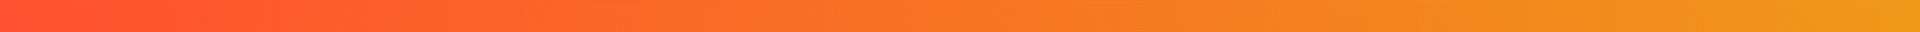

### Baseline

Calculate the baseline accuracy score for the model.

In [33]:
acc_baseline = y_train.value_counts(normalize = True).max()
print("Baseline Accuracy:", round(acc_baseline, 4))

Baseline Accuracy: 0.969


In [34]:
rf_clf = RandomForestClassifier(random_state = 42)

In [35]:
rf_params = {
    "n_estimators": range(25, 100, 25),
    "max_depth": range(10, 50, 10)
}
rf_params

{'n_estimators': range(25, 100, 25), 'max_depth': range(10, 50, 10)}

In [36]:
gb_clf = GradientBoostingClassifier(random_state= 42)

In [37]:
gb_params = {
    "_n_estimators": range(20, 31, 5),
    "max_depth": range(2,5)
}